# FINAL MODEL 

This is our final model, the one that reached the highest avg classification accuracy on the test set of Phase 1. It is based on fine tuning with the VGG-16 model, rearranging just the last three convolutional layers.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
%cd /gdrive/My Drive/Colab Notebooks/ANN&DL First Challenge/dataset

/gdrive/My Drive/Colab Notebooks/ANN&DL First Challenge/dataset


In [3]:
# IMPORT ALL THE LIBRARIES 
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

!pip install visualkeras
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

     |████████████████████████████████| 795 kB 8.2 MB/s 
2.7.0


In [4]:
# FIX RANDOM SEED FOR REPRODUCIBILITY 
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Dataset 

In [ ]:
!unzip dataset.zip

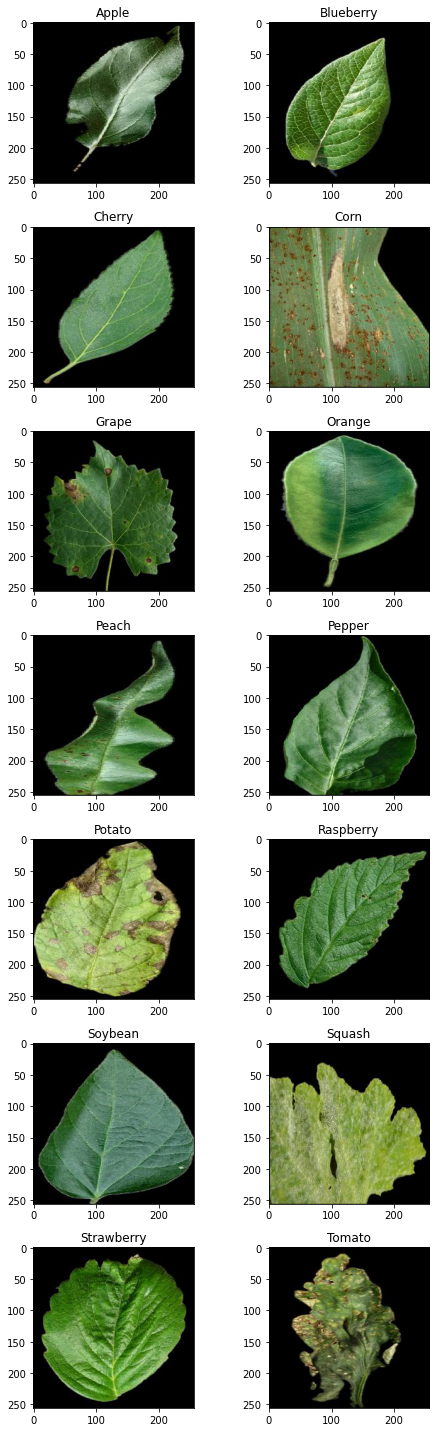

In [9]:
# VISUALIZE THE DATASET

# Define dataset directry 
dataset_dir = 'training'

# Classes 
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

# Plot example images from dataset
esegui_plot = True
if esegui_plot == True:
  num_row = len(labels)//2
  num_col = len(labels)//num_row
  fig, axes = plt.subplots(num_row, num_col, figsize=(1*num_row,10*num_col))
  for i in range(len(labels)):
    if i < len(labels):
      class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
      class_img = class_imgs[0]
      img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
      ax = axes[i//num_col, i%num_col]
      ax.imshow(np.array(img))
      ax.set_title('{}'.format(labels[i]))
  plt.tight_layout()
  plt.show()
  

In [10]:
# Define a generator 

from tensorflow.keras.applications.vgg16 import preprocess_input

train_data_gen = ImageDataGenerator(validation_split=0.2,
                                     rotation_range=30,
                                     height_shift_range=50,
                                     width_shift_range=50,
                                     zoom_range=0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True, 
                                     fill_mode='constant',
                                     rescale = 1/255,
                                     preprocessing_function = preprocess_input) # NB!!

# Set batch size 
batch_size = 8

# Training set generation
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed,
                                               subset="training")
# Validation set generation 
val_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed,
                                               subset="validation")

# Set weights for balanced training of the model (not considered in the end)
counter = Counter(train_gen.labels)
max_val = float(max(counter.values()))
class_weights = {
   class_id: max_val / num_images
   for class_id,
   num_images in counter.items()
}
print(class_weights)

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.
{0: 5.758533501896334, 1: 12.179144385026738, 2: 9.753747323340471, 3: 4.72020725388601, 4: 3.9031705227077977, 5: 3.2558970693352394, 6: 5.824808184143222, 7: 7.44281045751634, 8: 7.949389179755672, 9: 21.485849056603772, 10: 3.5228151585460172, 11: 9.902173913043478, 12: 8.450834879406308, 13: 1.0}


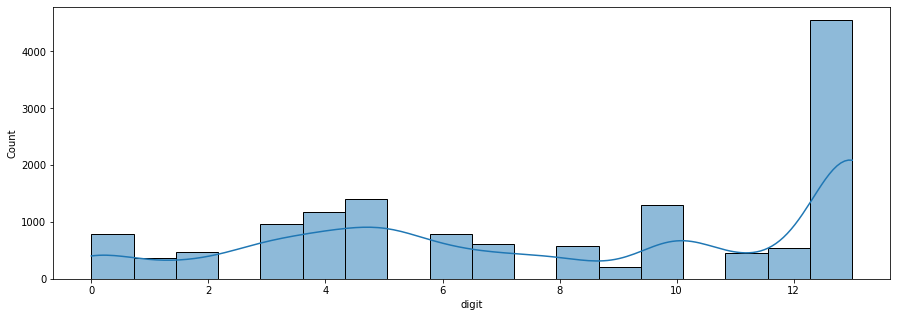

In [11]:
# Open a new plot figure of the specified size 
plt.figure(figsize=(15,5))
# Plot an histogram that counts the number of images in the dataset for each one of the 10 classes 
sns.histplot(data=pd.DataFrame(train_gen.classes, columns=['digit']), x='digit', kde=True)
# Show the plot 
plt.show()

In [ ]:
# Define auxiliary function for batch selection 
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

# Check that it works properly 
apply_get_next_batch = True
if apply_get_next_batch == True:
  _ = get_next_batch(train_gen)
if apply_get_next_batch == True:
  _ = get_next_batch(val_gen)

## Fine Tuning - VGG_16

In [ ]:
input_shape = (256, 256, 3)
epochs = 20

In [ ]:
# Import Vgg16 informations 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Model vgg16
vgg_model = VGG16(include_top=False,
                  weights="imagenet",
                  input_shape=(224,224, 3))

for layer in vgg_model.layers:
    layer.trainable = True
for i, layer in enumerate(vgg_model.layers[:14]):
    layer.trainable=False
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)
    
inputs = tfk.Input(shape=(256,256,3))
resizing = tfkl.Resizing(224,224)(inputs)
x = vgg_model(resizing)

# Maxpooling Layer 01
maxpool1 = tfkl.MaxPooling2D(name = 'Pooling1')(x)

# Convolution Layer  
conv1 = tfkl.Conv2D(
    filters = 512,
    kernel_size=(3, 3),
    strides = (1, 1),
    padding = 'same',
    activation = 'relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed)
)(maxpool1)

# Maxpooling Layer 02
maxpool2 = tfkl.MaxPooling2D(name = 'Pooling2')(conv1)

# Flattening Layer 
flat1 = Flatten()(maxpool2)

# Dense classification layer #1
class1 = Dense(256, activation='relu')(flat1)

# Dropout 01
dropout_layer_1 = tfkl.Dropout(0.4, seed=seed)(class1)

# Dense classification layer #2
# class2 = Dense(128, activation='relu')(dropout_layer_1)
# Dropout 02
# dropout_layer_2 = tfkl.Dropout(0.4, seed=seed)(class2)

# Dense output layer 
output = Dense(14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(dropout_layer_1)

#model = Model(inputs = vgg_model.inputs, outputs = output)
model = Model(inputs = inputs, outputs = output)

In [ ]:
# Auxiliary function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
  
  # creates folders and callbacks, collected into a list, since the argument "callbacks" in the function .fit() requires a list

  exps_dir = os.path.join('models')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir) # creates and SETS the directory if not found

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
                                                                  # histogram_freq = 5 means that i want to save 1 in 5 epochs (e.g. 1, 6, 6+5, ...)
                                                                  # histogram_freq = 1 means that i want to save 1 in 5 epochs (e.g. 1, 2, 3, ...)
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks



## Training Phase

In [ ]:
# Model Summary 
model.summary()

# Taining specifics
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')


In [ ]:
# Train the model
first_try_callbacks = create_folders_and_callbacks(model_name='CNN_first_try')

history = model.fit(
    x = train_gen,         
    epochs = epochs,
    callbacks = [first_try_callbacks,
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)],
    validation_data = val_gen
).history

## Results visualization 

In [ ]:
# TRAINING VISUALIZATION 

# Plot the training error & the validation error 
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy Loss Function')
plt.grid(alpha=.3)


# Plot the accuracy level in training and validation
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8)
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Confution Matrix
Y_pred = model.predict_generator(val_gen, 14189 // batch_size +1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_gen.classes, y_pred))
